<div style="border:2px solid #2196F3; border-radius:10px; padding:16px; background:#f9f9ff">

<h3>⚙️ Notebook 2 — Preprocessing & Baseline Modeling</h3>

**Purpose**  
- Load the curated dataset (~54 features) derived from Notebook 1.  
- Apply preprocessing:  
  - Handle missing values  
  - Encode categorical variables  
  - Scale numerical features  
- Split data into train/test sets.  
- Train baseline models (Logistic Regression, Random Forest, XGBoost) to establish performance benchmarks.  
- Evaluate using ROC-AUC, LogLoss, precision/recall, and calibration plots.  

**Inputs**  
- <code>data/processed/loan_default_slim55.parquet</code> (default, safe to load in-memory)  
- <code>data/processed/loan_default_full55.parquet</code> (already prepared in Notebook 1, only load in downstream notebooks if resources allow)  
- <code>columns_to_keep.txt</code> (list of selected features)  

**Outputs**  
- Preprocessing pipeline object  
- Baseline model artifacts for comparison in Notebook 3  

⚠️ **Memory Reminder**  
Do not flip `USE_SAMPLE=False` in Notebook 1. The full dataset is already saved as <code>loan_default_full55.parquet</code>.  
Notebook 2 should always start from the slim55 sample for exploration and prototyping. The full dataset can be used later for scaling experiments if hardware permits.  

</div>

### <div class="alert alert-info" align = center> Imports</div>

In [1]:
# Core
import os, sys, json, pathlib, warnings, time, joblib
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing & modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_fscore_support, roc_auc_score, log_loss, 
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay,brier_score_loss, log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve

# Gradient boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Utility
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

#Start a timer to check the execution time of the notebook.
start_time = time.time()

<div class="alert alert-info"><strong>Load The Data</strong></div>

In [2]:
# === Dataset Loading ===

USE_SAMPLE = False  # Keep this True for now, flip to False when ready for full dataset

# Paths
datapath = pathlib.Path("data/processed")
feat_file = pathlib.Path("data/processed/columns_to_keep.txt")
full_feat_file = pathlib.Path("data/processed/full_columns_to_keep.txt")

# Load kept features
if USE_SAMPLE:
    print("🔹 Using SAMPLE dataset (10%)")
    with open(feat_file) as f:
        features_to_keep = [line.strip() for line in f if line.strip()]
    df = pd.read_parquet(datapath / "loan_default_slim55.parquet") # Load the whole slim file.
else:
    print("🔹 Using FULL dataset")
    with open(full_feat_file) as f:
        features_to_keep = [line.strip() for line in f if line.strip()]
    df = pd.read_parquet(datapath / "loan_default_full51.parquet")

# Always include target
target = "target_default"
features_final = features_to_keep

# Keep only final features + target
df = df[features_final]

print(f"✅ Loaded dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")
df.head()

🔹 Using FULL dataset
✅ Loaded dataset: 1,329,272 rows, 51 columns


,loan_amnt,funded_amnt_inv,int_rate,annual_inc,mths_since_last_record,open_acc,pub_rec,out_prncp,out_prncp_inv,total_rec_prncp,...,mths_since_last_delinq_is_missing,mths_since_last_major_derog_is_missing,annual_inc_joint_is_missing,il_util_is_missing,mths_since_recent_bc_dlq_is_missing,mths_since_recent_revol_delinq_is_missing,target_default,emp_length,emp_length_is_missing,int_rate_trunc
0,30000.0,30000.0,22.350000,100000.0,84.0,11.0,1.0,0.0,0.0,30000.0,...,0,1,0,0,1,1,0,5 years,0,22.3500
1,40000.0,40000.0,16.139999,45000.0,74.0,18.0,0.0,0.0,0.0,40000.0,...,1,1,0,0,1,1,0,< 1 year,0,16.1399
2,20000.0,20000.0,7.560000,100000.0,74.0,9.0,0.0,0.0,0.0,20000.0,...,0,1,0,0,1,0,0,10+ years,0,7.5599
3,4500.0,4500.0,11.310000,38500.0,74.0,12.0,0.0,0.0,0.0,4500.0,...,0,0,1,0,1,1,0,10+ years,0,11.3100
4,8425.0,8425.0,27.270000,450000.0,74.0,21.0,0.0,0.0,0.0,8425.0,...,1,1,0,0,1,1,0,3 years,0,27.2700


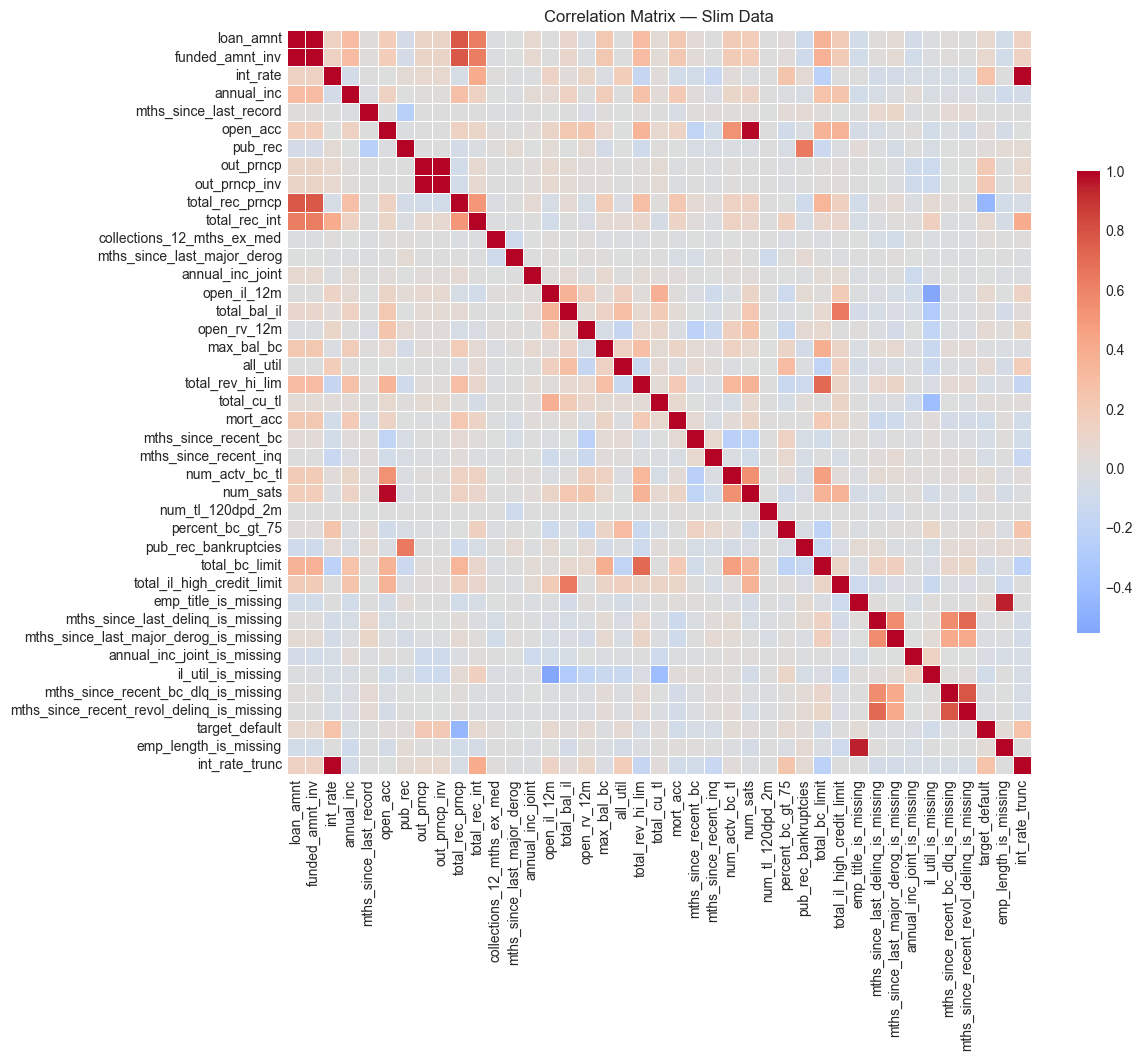

In [3]:
# Numeric-only correlation
corr = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True,
            cbar_kws={"shrink": .6}, linewidths=0.5)
plt.title("Correlation Matrix — Slim Data")
plt.show()

Top correlations with target_default:


total_rec_prncp      -0.448944
int_rate              0.263987
int_rate_trunc        0.263987
out_prncp             0.212828
out_prncp_inv         0.212816
il_util_is_missing   -0.084022
mort_acc             -0.077391
loan_amnt             0.071901
funded_amnt_inv       0.071863
total_bc_limit       -0.068719
open_il_12m           0.067254
total_rec_int         0.066027
percent_bc_gt_75      0.062121
all_util              0.060492
open_rv_12m           0.057654
Name: target_default, dtype: float64

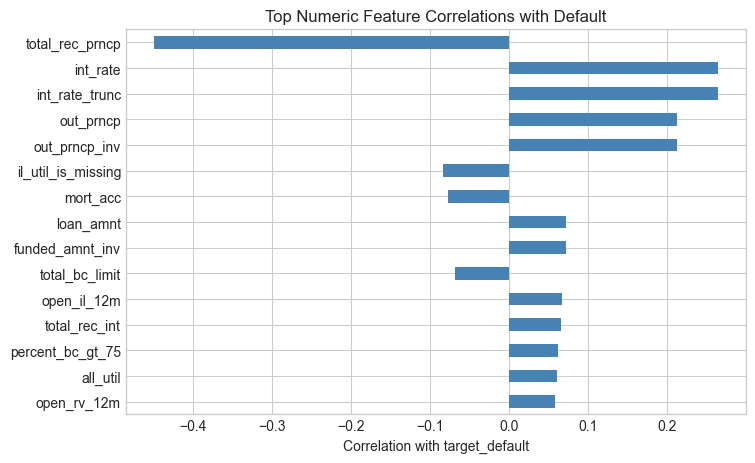

In [4]:
# --- Target vs Feature Correlation ---
target = "target_default"

# Correlation matrix
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Series of correlations with target (drop itself)
corr_with_target = corr_matrix[target].drop(target)

# Sort by absolute value using the "by" argument
corr_with_target = corr_with_target.iloc[corr_with_target.abs().argsort()[::-1]]

# Display top correlations
print("Top correlations with target_default:")
display(corr_with_target.head(15))

# Plot bar chart
plt.figure(figsize=(8, 5))
corr_with_target.head(15).plot(kind="barh", color="steelblue")
plt.title("Top Numeric Feature Correlations with Default")
plt.xlabel("Correlation with target_default")
plt.gca().invert_yaxis()
plt.show()

target_default
0    0.783852
1    0.216148
Name: proportion, dtype: float64


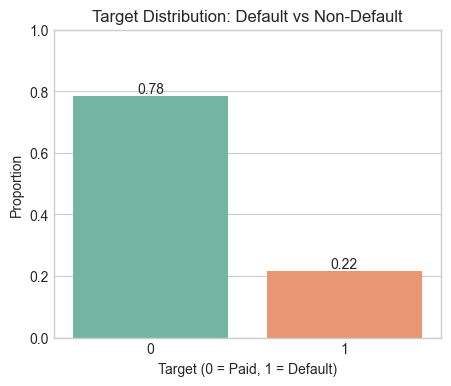

In [5]:
# --- Target Distribution ---
dist = df["target_default"].value_counts(normalize=True).rename("proportion")

print(dist)

plt.figure(figsize=(5,4))
sns.barplot(x=dist.index.astype(str), y=dist.values, palette="Set2")
plt.title("Target Distribution: Default vs Non-Default")
plt.ylabel("Proportion")
plt.xlabel("Target (0 = Paid, 1 = Default)")
for i, v in enumerate(dist.values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=10)
plt.ylim(0,1)
plt.show()

<div style="border:2px solid #FF9800; border-radius:10px; padding:14px; background:#FFF8E1">

<h3>⚠️ Target Distribution — Class Imbalance</h3>

- <b>Non-Default (0):</b> ~90% (78% on full data) 
- <b>Default (1):</b> ~10% (22% on full data) 

This imbalance means that a naive model predicting "0" for all cases would still achieve ~90% accuracy.  
Therefore, evaluation will emphasize **recall, precision, F1, ROC-AUC, and calibrated probabilities** rather than raw accuracy.  

</div>

<div style="border:2px solid #3F51B5; border-radius:10px; padding:16px; background:#f5f5ff">

<h3>⚙️ Scaling & Feature Transformation Strategy</h3>

**Why Scale?**  
Our dataset contains a mix of raw financial amounts (e.g., loan amounts, balances) and ratio-like indicators (e.g., interest rate, debt-to-income).  
These features exist on very different scales and distributions, which can bias distance-based models and gradient-based optimizers.  

**Approach**  
- **RobustScaler** → for highly skewed monetary features (e.g., loan_amnt, dti, revol_util).  
  - Robust to outliers, centers data by median, scales by IQR.  
- **StandardScaler** → for ratio-like or bounded features closer to normal distributions (e.g., int_rate, delinq_2yrs, total_acc).  
  - Mean-centered, unit variance scaling.  
- **Passthrough (no scaling)** → categorical features, which will be one-hot encoded.  
  - These are not numeric in nature, so scaling is unnecessary.

**Imbalance Handling**  
Target distribution is imbalanced (~90% non-default, ~10% default).  
We will:  
- Apply **class weights** to penalize misclassification of defaults more heavily.  
- Explore **threshold tuning** later to balance recall vs precision.  

This ensures preprocessing preserves interpretability while giving all models a fair chance to learn meaningful patterns.  

</div>

In [6]:
df["target_default"].isna().sum()

np.int64(0)

In [7]:
df.shape

(1329272, 51)

In [8]:
# Split features by dtype
target = "target_default"
num_feats = df.select_dtypes(include=[np.number]).columns.drop(target).tolist()
cat_feats = [c for c in df.columns if c not in num_feats + [target]]

# Transformers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe",     OneHotEncoder(handle_unknown="ignore", drop="if_binary"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_feats),
        ("cat", categorical_transformer, cat_feats),
    ],
    remainder="drop"  # only keep transformed columns
)

# Train/test split
X = df.drop(columns=[target])
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Pipeline: preprocess + model
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:, 1]


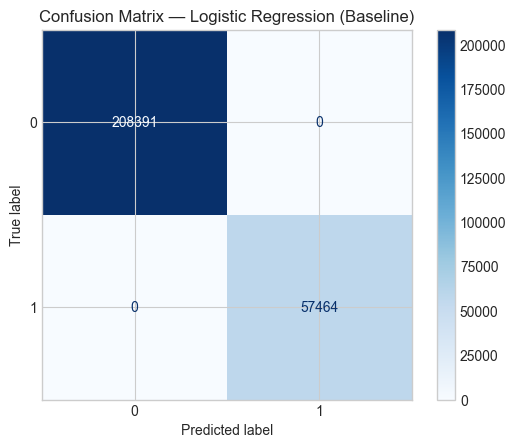

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    208391
           1       1.00      1.00      1.00     57464

    accuracy                           1.00    265855
   macro avg       1.00      1.00      1.00    265855
weighted avg       1.00      1.00      1.00    265855

ROC-AUC: 1.0000


In [9]:
# Predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix — Logistic Regression (Baseline)")
plt.show()

# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")


In [10]:
print([c for c in X_train.columns if "pymnt" in c or "rec" in c or "out_prncp" in c or "status" in c])

['mths_since_last_record', 'pub_rec', 'out_prncp', 'out_prncp_inv', 'total_rec_prncp', 'total_rec_int', 'mths_since_recent_bc', 'mths_since_recent_inq', 'pub_rec_bankruptcies', 'verification_status', 'loan_status', 'last_pymnt_d', 'mths_since_recent_bc_dlq_is_missing', 'mths_since_recent_revol_delinq_is_missing']


<div style="border:2px solid #FF5722; border-radius:10px; padding:16px; background:#fff7f5">

<h3>🚨 Perfect Score Detected — Target Leakage</h3>

**Observation**  
- Our baseline Logistic Regression returned a perfect score (ROC-AUC = 1.0, F1 = 1.0).  
- In practice, this is impossible for noisy, real-world credit data.  
- The cause is **target leakage**: some features directly reveal the loan’s repayment outcome, e.g.  
  - `loan_status` (direct label)  
  - `out_prncp`, `out_prncp_inv` (outstanding principal)  
  - `total_rec_prncp`, `total_rec_int` (repayments already made)  
  - `last_pymnt_d` (last payment date)  

**Action Taken**  
- We are **removing all post-loan performance features** (anything only observable after loan issuance).  
- The modeling dataset will now include only **origination-time borrower attributes and loan terms**.  

**Why This Matters**  
- Ensures the model mimics real-world deployment: predicting default **before issuing a loan**, not after repayment begins.  
- Prevents artificially inflated metrics and forces the model to rely on genuine predictive signals (e.g., credit history, DTI, income, loan purpose).  

✅ Going forward, performance will drop from the “perfect” scores, but results will be **realistic, trustworthy, and business-relevant**.  

</div>

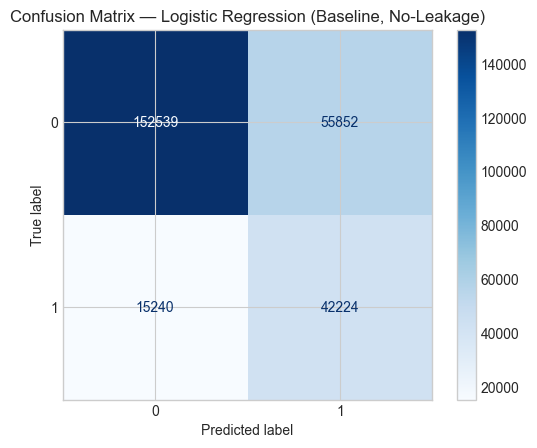

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81    208391
           1       0.43      0.73      0.54     57464

    accuracy                           0.73    265855
   macro avg       0.67      0.73      0.68    265855
weighted avg       0.81      0.73      0.75    265855

ROC-AUC: 0.8094


In [11]:
# 0) Remove leakage columns
leakage_cols = [
    "loan_status","out_prncp","out_prncp_inv","total_rec_prncp","total_rec_int",
    "total_pymnt","total_pymnt_inv","last_pymnt_d","last_pymnt_amnt",
    "recoveries","collection_recovery_fee"
]
df_model = df.drop(columns=[c for c in leakage_cols if c in df.columns]).copy()

# 1) Split features
target = "target_default"
num_feats = df_model.select_dtypes(include=[np.number]).columns.drop(target).tolist()
cat_feats = [c for c in df_model.columns if c not in num_feats + [target]]

# 2) Preprocess + model (logreg, class-weighted)
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_feats),
    ("cat", categorical_transformer, cat_feats),
], remainder="drop")

X = df_model.drop(columns=[target])
y = df_model[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

clf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
clf.fit(X_train, y_train)

# 3) Predictions + metrics
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix — Logistic Regression (Baseline, No-Leakage)")
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")


In [12]:
# --- Shared prep (run once) ---


target = "target_default"

# Drop known leakage columns if still present
leakage_cols = [
    "loan_status","out_prncp","out_prncp_inv","total_rec_prncp","total_rec_int",
    "total_pymnt","total_pymnt_inv","last_pymnt_d","last_pymnt_amnt",
    "recoveries","collection_recovery_fee"
]
df_model = df.drop(columns=[c for c in leakage_cols if c in df.columns]).copy()
df_model = df_model[df_model[target].isin([0,1])].copy()
df_model[target] = df_model[target].astype(int)

# Split features by dtype
num_feats = df_model.select_dtypes(include=[np.number]).columns.drop(target).tolist()
cat_feats = [c for c in df_model.columns if c not in num_feats + [target]]

# Preprocessor
numeric_tf = Pipeline([("imputer", SimpleImputer(strategy="mean")),
                       ("scaler",  StandardScaler())])
categorical_tf = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                           ("ohe",     OneHotEncoder(handle_unknown="ignore", drop="if_binary"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_feats),
        ("cat", categorical_tf, cat_feats),
    ],
    remainder="drop"
)

X = df_model.drop(columns=[target])
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# For boosted trees: class imbalance weight
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos
scale_pos_weight


np.float64(3.6264487331198665)

ROC-AUC: 0.8094
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81    208391
           1       0.43      0.73      0.54     57464

    accuracy                           0.73    265855
   macro avg       0.67      0.73      0.68    265855
weighted avg       0.81      0.73      0.75    265855



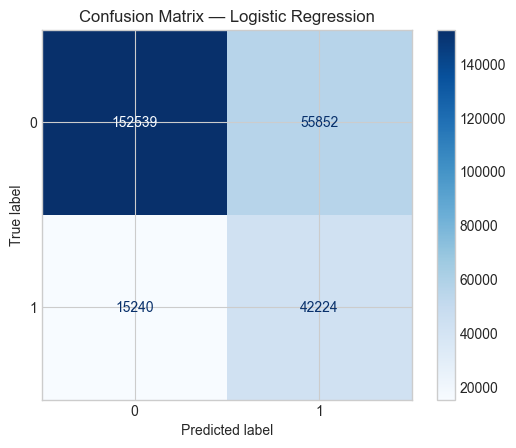

In [13]:


logreg = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

logreg.fit(X_train, y_train)
y_prob_lr = logreg.predict_proba(X_test)[:, 1]
y_pred_lr = (y_prob_lr >= 0.5).astype(int)

print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

cm = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()


[LightGBM] [Info] Number of positive: 229856, number of negative: 833561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4575
[LightGBM] [Info] Number of data points in the train set: 1063417, number of used features: 399
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216149 -> initscore=-1.288254
[LightGBM] [Info] Start training from score -1.288254
ROC-AUC: 0.8316
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.75      0.82    208391
           1       0.45      0.75      0.57     57464

    accuracy                           0.75    265855
   macro avg       0.68      0.75      0.70    265855
weighted avg       0.82      0.75      0.77    265855



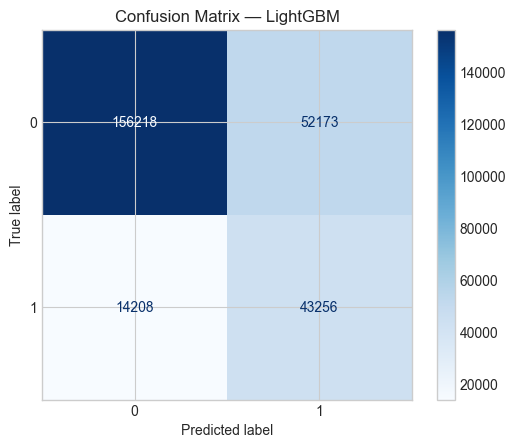

In [14]:
lgbm = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        class_weight=None,                # use scale_pos_weight instead
        scale_pos_weight=scale_pos_weight
    ))
])

lgbm.fit(X_train, y_train)
y_prob_lgb = lgbm.predict_proba(X_test)[:, 1]
y_pred_lgb = (y_prob_lgb >= 0.5).astype(int)

print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_lgb):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_lgb))

cm = confusion_matrix(y_test, y_pred_lgb)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — LightGBM")
plt.show()


ROC-AUC: 0.8253
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.75      0.82    208391
           1       0.45      0.74      0.56     57464

    accuracy                           0.75    265855
   macro avg       0.68      0.74      0.69    265855
weighted avg       0.81      0.75      0.77    265855



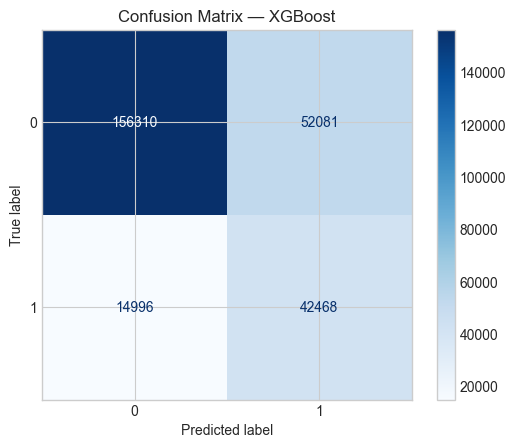

In [15]:
xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        eval_metric="logloss",
        tree_method="hist",
        scale_pos_weight=scale_pos_weight
    ))
])

xgb.fit(X_train, y_train)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — XGBoost")
plt.show()


In [16]:
def summarize(name, y_true, y_prob):
    print(f"{name:10s} | AUROC={roc_auc_score(y_true, y_prob):.4f} | LogLoss={log_loss(y_true, y_prob):.4f}")

summarize("LogReg",  y_test, y_prob_lr)
summarize("LightGBM",y_test, y_prob_lgb)
summarize("XGBoost",y_test, y_prob_xgb)


LogReg     | AUROC=0.8094 | LogLoss=0.5337
LightGBM   | AUROC=0.8316 | LogLoss=0.5026
XGBoost    | AUROC=0.8253 | LogLoss=0.5115


<div style="border:2px solid #2196F3; border-radius:10px; padding:16px; background:#f9f9ff">

<h3>🔎 Midway Summary — Notebook 2 (Preprocessing & Baseline)</h3>

**Data & Setup**
- Leakage removed (post-loan performance fields dropped).
- Preprocessing: mean-impute + StandardScaler for numerics; most-frequent + OneHot for categoricals.

**Baselines (probability-focused)**
- Logistic Regression — AUROC: **0.8094**, LogLoss: **0.5337**
- LightGBM — AUROC: **0.8316**, LogLoss: **0.5026** ✅ *current winner*
- XGBoost — AUROC: **0.8253**, LogLoss: **0.5115**

**Implication**
- LightGBM offers the strongest ranking (AUROC) and best probability quality (lowest LogLoss). Proceed with LightGBM for calibration/threshold analysis and saving model artifacts.

</div>


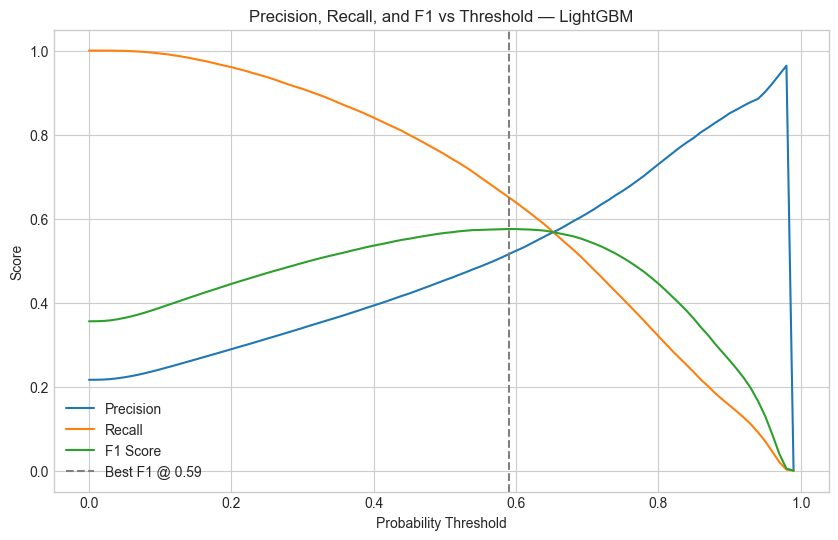

Best F1 threshold ≈ 0.59  (F1=0.575)


In [17]:
# Requires: y_test, y_prob_lgb already computed
thresholds = np.linspace(0.0, 0.99, 100)

prec, rec, f1 = [], [], []
for t in thresholds:
    yp = (y_prob_lgb >= t).astype(int)
    p, r, f, _ = precision_recall_fscore_support(y_test, yp, average="binary", zero_division=0)
    prec.append(p); rec.append(r); f1.append(f)

best_idx = int(np.argmax(f1))
best_t = float(thresholds[best_idx])
best_f1 = float(f1[best_idx])

plt.figure(figsize=(10,6))
plt.plot(thresholds, prec, label="Precision")
plt.plot(thresholds, rec,  label="Recall")
plt.plot(thresholds, f1,   label="F1 Score")
plt.axvline(best_t, ls="--", color="gray", label=f"Best F1 @ {best_t:.2f}")
plt.xlabel("Probability Threshold"); plt.ylabel("Score"); plt.title("Precision, Recall, and F1 vs Threshold — LightGBM")
plt.legend(); plt.grid(True); plt.show()

print(f"Best F1 threshold ≈ {best_t:.2f}  (F1={best_f1:.3f})")


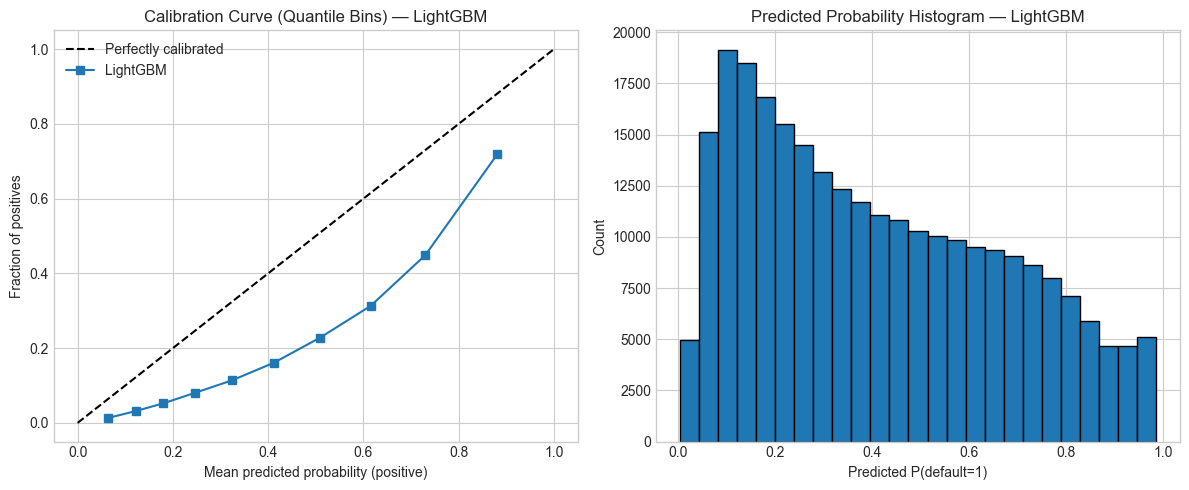

Brier Score: 0.1666
Log Loss:    0.5026


In [18]:
# quantile calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob_lgb, n_bins=10, strategy="quantile")
brier = brier_score_loss(y_test, y_prob_lgb)
ll    = log_loss(y_test, y_prob_lgb)

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# calibration
ax[0].plot([0,1],[0,1], "k--", label="Perfectly calibrated")
ax[0].plot(prob_pred, prob_true, marker="s", label="LightGBM")
ax[0].set_title("Calibration Curve (Quantile Bins) — LightGBM")
ax[0].set_xlabel("Mean predicted probability (positive)")
ax[0].set_ylabel("Fraction of positives")
ax[0].legend()

# histogram
ax[1].hist(y_prob_lgb, bins=25, edgecolor="black")
ax[1].set_title("Predicted Probability Histogram — LightGBM")
ax[1].set_xlabel("Predicted P(default=1)")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

print(f"Brier Score: {brier:.4f}")
print(f"Log Loss:    {ll:.4f}")


In [19]:
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# pick a deployment threshold — use best F1 by default (or change to business rule)
deploy_threshold = best_t if "best_t" in globals() else 0.5

# recompute core metrics at this threshold
y_pred_deploy = (y_prob_lgb >= deploy_threshold).astype(int)
p, r, f, _ = precision_recall_fscore_support(y_test, y_pred_deploy, average="binary", zero_division=0)
auroc = float(roc_auc_score(y_test, y_prob_lgb))
ll    = float(log_loss(y_test, y_prob_lgb))
brier = float(brier)

# save pipeline
pipe_path = models_dir / "lgbm_pipeline.joblib"
joblib.dump(lgbm, pipe_path)

# save metadata
meta = {
    "model": "LightGBM",
    "pipeline_file": str(pipe_path),
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "deploy_threshold": round(deploy_threshold, 4),
    "metrics": {
        "auroc": round(auroc, 4),
        "logloss": round(ll, 4),
        "brier": round(brier, 4),
        "precision_at_threshold": round(float(p), 4),
        "recall_at_threshold": round(float(r), 4),
        "f1_at_threshold": round(float(f), 4),
    },
    "train_test_sizes": {
        "train": int(len(y_train)),
        "test": int(len(y_test))
    },
    "feature_groups": {
        "numeric": num_feats,
        "categorical": cat_feats
    }
}
with open(models_dir / "lgbm_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

print("✅ Saved:")
print(" •", pipe_path)
print(" •", models_dir / "lgbm_metadata.json")


✅ Saved:
 • models\lgbm_pipeline.joblib
 • models\lgbm_metadata.json


In [20]:
# Reload and score to verify artifacts work end-to-end
pipe_loaded = joblib.load("models/lgbm_pipeline.joblib")
y_prob_chk  = pipe_loaded.predict_proba(X_test)[:,1]
print("Reload AUROC:", roc_auc_score(y_test, y_prob_chk).round(4))

Reload AUROC: 0.8316


<div style="border:2px solid #2196F3; border-radius:10px; padding:16px; background:#f9f9ff"> <h3>✅ Notebook 2 — Summary & Hand-off</h3>

<b>What we did</b>

Removed post-loan leakage features and built a clean preprocessing pipeline (impute + scale numerics, impute + OHE categoricals).

Trained three probability models and compared on the test set.

<b>Head-to-head (probability quality)</b>

Logistic Regression — AUROC: <b>0.8094</b>, LogLoss: <b>0.5337</b>

XGBoost — AUROC: <b>0.8253</b>, LogLoss: <b>0.5115</b>

<b>LightGBM (winner)</b> — AUROC: <b>0.8316</b>, LogLoss: <b>0.5026</b>

<b>Threshold & calibration (LightGBM)</b>

Best F1 threshold ≈ <b>0.59</b> (F1 ≈ <b>0.575</b>).

Brier score: <b>0.1666</b>; log loss: <b>0.5026</b>.

Calibration curve indicates mild <i>over-confidence</i> at mid–high scores → candidate for isotonic calibration in Notebook 3.

<b>Artifacts saved</b>

Pipeline (preprocess + LightGBM): <code>models/lgbm_pipeline.joblib</code>

Metadata (metrics, threshold, feature lists): <code>models/lgbm_metadata.json</code>

Reload check passed: AUROC = <b>0.8316</b>.

<b>Next (Notebook 3)</b>

Calibrate (isotonic / Platt), cross-validate tuned LightGBM, compare probability calibration.

SHAP/global importance for interpretability.

Business thresholds & uplift tables for actionability.

</div>

In [21]:
#Stop the timer to check the execution time of the notebook.
end_time = time.time()
print(f"Total execution time: {round(end_time - start_time, 2)} seconds")

Total execution time: 109.2 seconds
